In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "../scripts")

from swe_2d import ShallowTwo, ShallowTwoFilter, ShallowTwoFilterPETSc
from statfenics.utils import build_observation_operator

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(2, 1), 32, 16)
params = {"nu": 1e-4, "C": 0., "H": 0.053, "u_inflow": 0.004, "inflow_period": 120}
control = {"dt": 0.01,
           "theta": 0.5,
           "simulation": "laminar",
           "use_imex": False,
           "use_les": False}
swe = ShallowTwoFilterPETSc(mesh, params, control, comm=fe.MPI.comm_world)
assert swe.L == 2.
assert swe.B == 1.

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

In [3]:
# setup filter (basically compute prior additive noise covariance)
rho = 1
ell = 0.5
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=0.5,
                   k_init_u=16, k_init_v=16, k_init_h=16, k=16)
swe.setup_filter(stat_params)
swe.setup_prior_covariance()

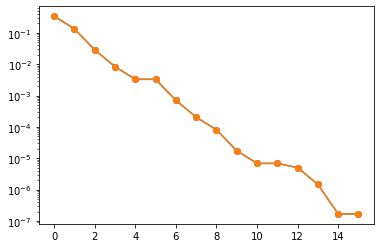

In [4]:
plt.semilogy(swe.spec_dens_u, "o-")
plt.semilogy(swe.spec_dens_v, "o-")
plt.show()

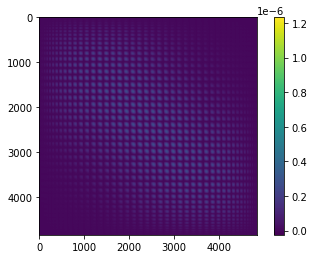

In [5]:
G_petsc = swe.G_sqrt.getDenseArray()
im = plt.imshow(G_petsc @ G_petsc.T)
plt.colorbar(im)
plt.show()

In [6]:
t = 0.
t_final = 1.
nt = np.int32(np.round(t_final / control["dt"]))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    swe.set_prev()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.14it/s]


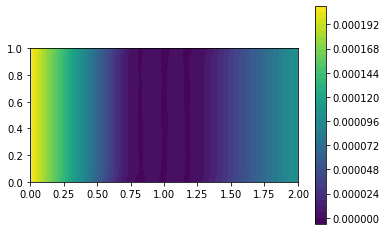

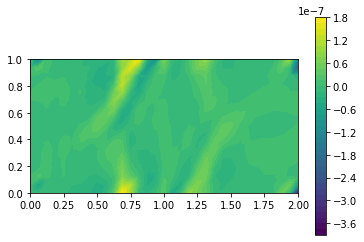

In [7]:
vel, h = swe.du.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

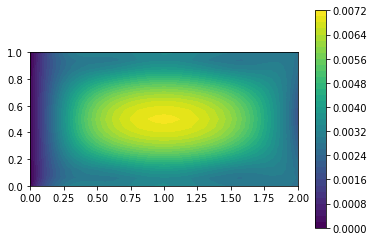

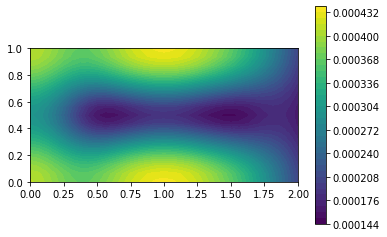

In [8]:
var_v = np.sqrt(np.sum(swe.cov_sqrt.getDenseArray()**2, axis=1))
var_f = fe.Function(swe.W)
var_f.vector().set_local(var_v)

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [9]:
t += swe.dt
%load_ext line_profiler
%lprun -f swe.prediction_step swe.prediction_step(t)
swe.set_prev()

Timer unit: 1e-06 s

Total time: 0.141889 s
File: /home/connor/Projects/20220609-swfe/docs/../scripts/swe_2d.py
Function: prediction_step at line 893

Line #      Hits         Time  Per Hit   % Time  Line Contents
   893                                               def prediction_step(self, t):
   894                                                   # push-forward
   895         1       7152.0   7152.0      5.0          self.solve()
   896         1         42.0     42.0      0.0          self.mean.setArray(self.du.vector().get_local())
   897                                           
   898                                                   # TODO(connor): reuse sparsity patterns?
   899         1      54116.0  54116.0     38.1          self.assemble_derivatives()
   900         1         15.0     15.0      0.0          self.ksp_propagation.setOperators(self.J_mat.mat())
   901                                           
   902                                                   # and 